<a href="https://colab.research.google.com/github/dalatorrem/Diplomado_Metodos_UCentral_2023/blob/main/Lectura_27_Logistic_Regression_stud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

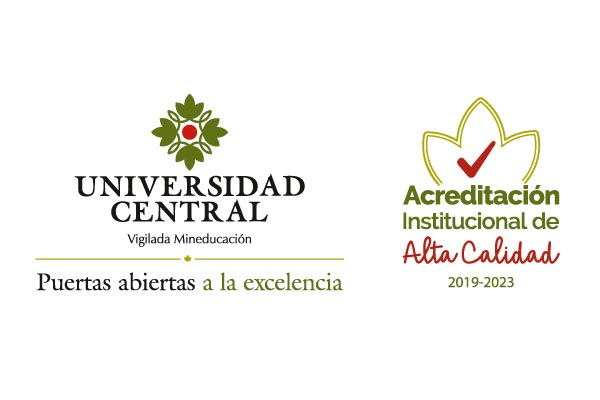

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
##
from scipy.stats     import chi2_contingency, ttest_ind
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import precision_recall_fscore_support, ConfusionMatrixDisplay
from sklearn.metrics import auc, roc_curve, roc_auc_score
##
import statsmodels.formula.api  as smf                              ## Modelos lineal.
import statsmodels.api  as sm
##
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15,6)
warnings.filterwarnings('ignore')
url_base = 'https://raw.githubusercontent.com/lacamposm/Metodos_Estadisticos/main/data/'

Modelo lineal...

$$Y=X\beta+ϵ$$

## ***Regresión logística***

En una regresión logística se tiene una variable objetivo $Y$ la cual es binaria y es de interés para el investigador. Se quiere construir una función $f(X)$ donde $X=(X_1, \ldots, X_p)$ es un conjunto de variables explicativas que se utilizarán para pronosticar a $Y$.

En un modelo de regresión lineal logística, se usan las funciones del tipo:
$$\ln \left(\frac{p}{1-p} \right)=\beta_0 +\beta_1X_1+\beta_2X_2+...+\beta_pX_p  $$

donde $p=P(Y=1)$

## ***Introducción***

Vamos a pensar que una persona solicita un crédito en linea, rechazar a cualquier persona sin una fuente de ingresos verificada es una política relevante que las plataformas de préstamos pueden implementar para ayudar a reducir la tasa de préstamos incobrables. Es natural sospechar que si no se puede verificar la fuente de ingresos de una persona, entonces podría incumplir con el préstamo. Sin embargo, desde la perspectiva de quien solicita el préstamo, el proceso de verificación puede ser engorroso y lento, y es posible que simplemente cambie a otra plataforma debido a este inconveniente.

Luego vamos a buscar responder la pregunta:

_**¿Se debería verificar la fuente de ingresos de un solicitante de préstamo en línea antes de aprobar su préstamo?**_


Para buscar resolver esta pregunta vamos a usar un Dataset que se obtiene de [LendingClub (LC) Statistics](https://www.lendingclub.com/info/download-data.action) y contienen todos los préstamos emitidos entre 2007 y 2012 junto con su estado actual de préstamo, es decir, ***totalmente pagado (Fully Paid) o no pagado (Charged Off).***

Usaremos ***la regresión logística***, para buscar responder a nuestra pregunta. Así, la idea de la lectura es cubrir los siguientes pasos:

1. Explorar el Dataset para tener una idea aproximada de cómo cada variable en el conjunto de datos interactúa con el estado actual del préstamo.

2. observe los posibles efectos de confusión.

3. Revisar el modelo de regresión logística.

4. Ajustar una serie de modelos de regresión logística para determinar ***si la verificación de la fuente de ingresos es significativa o no.***

## ***Situación contexto.***

En el siguiente Dataset tenemos registros de préstamos aprobados, la columna `loan_status` contiene la información si el préstamo fue pagado (`Fully Paid`) o no (`Charged Off`), además de las siguientes features:

|FEATURE|                                                 DESCRIPCIÓN|
|:-------------------|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|      annual_inc     |                                                 Los ingresos anuales autodeclarados proporcionados por el prestatario durante el registro.|
| verification_status |                                          Indica si los ingresos fueron verificados por LC, no verificados o si la fuente de ingresos fue verificada                                          |
|      emp_length     |                       Duración del empleo en años. Los valores posibles están entre 0 y 10, donde 0 significa menos de un año y 10 significa diez o más años.                      |
|    home_ownership   |             El estado de propiedad de la vivienda proporcionado por el prestatario durante el registro u obtenido del informe de crédito: RENT, OWN, MORTGAGE, OTHER            |
|       int_rate      |                                                                           Tasa de interés del préstamo                                                                          |
|      loan_amnt      | El monto del préstamo solicitado por el prestatario. Si en algún momento, el departamento de crédito reduce el monto del préstamo, se reflejará en este valor. |
|       purpose       |                                                           Una categoría proporcionada por el prestatario para la solicitud de préstamo.                                                          |
|         term        |                                             El número de pagos del préstamo. Los valores están expresados ​​en meses y pueden ser 36 o 60.                                             |
|        grade        |                                                                            Grado de préstamo asignado LC                                                                            |

In [ ]:
## Cargamos el DataSet
df_main = pd.read_csv(url_base + 'Logistic_Regression_1.csv')
df_main.head()

,loan_status,annual_inc,verification_status,emp_length,home_ownership,int_rate,loan_amnt,purpose,term,grade
0,Fully Paid,24000.0,Verified,10+ years,RENT,10.65%,5000,credit_card,36 months,B
1,Charged Off,30000.0,Source Verified,< 1 year,RENT,15.27%,2500,car,60 months,C
2,Fully Paid,12252.0,Not Verified,10+ years,RENT,15.96%,2400,small_business,36 months,C
3,Fully Paid,49200.0,Source Verified,10+ years,RENT,13.49%,10000,other,36 months,C
4,Fully Paid,80000.0,Source Verified,1 year,RENT,12.69%,3000,other,60 months,B


Realizamos una exploración rápida de lo que nos ingresa al sistema:

In [ ]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38705 entries, 0 to 38704
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   loan_status          38705 non-null  object 
 1   annual_inc           38705 non-null  float64
 2   verification_status  38705 non-null  object 
 3   emp_length           38705 non-null  object 
 4   home_ownership       38705 non-null  object 
 5   int_rate             38705 non-null  object 
 6   loan_amnt            38705 non-null  int64  
 7   purpose              38705 non-null  object 
 8   term                 38705 non-null  object 
 9   grade                38705 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 3.0+ MB


In [ ]:
## Inspección de las tipo object.
df_main.select_dtypes(include='object').head()

,loan_status,verification_status,emp_length,home_ownership,int_rate,purpose,term,grade
0,Fully Paid,Verified,10+ years,RENT,10.65%,credit_card,36 months,B
1,Charged Off,Source Verified,< 1 year,RENT,15.27%,car,60 months,C
2,Fully Paid,Not Verified,10+ years,RENT,15.96%,small_business,36 months,C
3,Fully Paid,Source Verified,10+ years,RENT,13.49%,other,36 months,C
4,Fully Paid,Source Verified,1 year,RENT,12.69%,other,60 months,B


In [ ]:
## Notemos que la feature int_rate no está en las medidas adecuadas. Lo correjimos.
df = df_main.copy()
df['int_rate'] = df['int_rate'].apply(lambda x: x.replace('%','')).astype('float')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38705 entries, 0 to 38704
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   loan_status          38705 non-null  object 
 1   annual_inc           38705 non-null  float64
 2   verification_status  38705 non-null  object 
 3   emp_length           38705 non-null  object 
 4   home_ownership       38705 non-null  object 
 5   int_rate             38705 non-null  float64
 6   loan_amnt            38705 non-null  int64  
 7   purpose              38705 non-null  object 
 8   term                 38705 non-null  object 
 9   grade                38705 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 3.0+ MB


In [ ]:
## Inspección de las object.
df.select_dtypes(include='object').head()

,loan_status,verification_status,emp_length,home_ownership,purpose,term,grade
0,Fully Paid,Verified,10+ years,RENT,credit_card,36 months,B
1,Charged Off,Source Verified,< 1 year,RENT,car,60 months,C
2,Fully Paid,Not Verified,10+ years,RENT,small_business,36 months,C
3,Fully Paid,Source Verified,10+ years,RENT,other,36 months,C
4,Fully Paid,Source Verified,1 year,RENT,other,60 months,B


In [ ]:
## Revisemos los valores únicos de cada feature categórica.
temp = df.select_dtypes(include='object')
##
print('='*100)
for feature in temp.columns:
  print(feature,':',temp[feature].unique())
  print('='*100)

loan_status : ['Fully Paid' 'Charged Off']
verification_status : ['Verified' 'Source Verified' 'Not Verified']
emp_length : ['10+ years' '< 1 year' '1 year' '3 years' '8 years' '9 years' '4 years'
 '5 years' '6 years' '2 years' '7 years']
home_ownership : ['RENT' 'OWN' 'MORTGAGE' 'OTHER']
purpose : ['credit_card' 'car' 'small_business' 'other' 'wedding'
 'debt_consolidation' 'home_improvement' 'major_purchase' 'medical'
 'moving' 'vacation' 'house' 'renewable_energy' 'educational']
term : [' 36 months' ' 60 months']
grade : ['B' 'C' 'A' 'E' 'F' 'D' 'G']


In [ ]:
## Inspeccionemos nuestra varible Target
display(df['loan_status'].value_counts())
print()
df['loan_status'].value_counts(normalize=True)

Fully Paid     33265
Charged Off     5440
Name: loan_status, dtype: int64

Fully Paid     0.85945
Charged Off    0.14055
Name: loan_status, dtype: float64

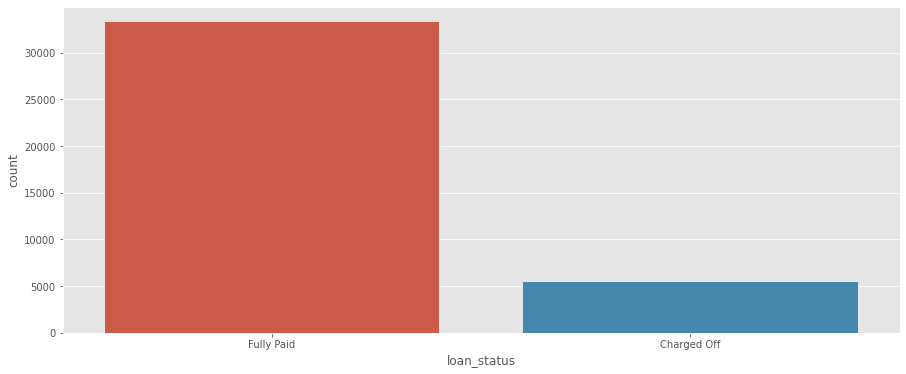

In [ ]:
## La información en la variable Target está desbalanceada.
sns.countplot(data=df, x='loan_status')
plt.show()

## ***Features versus Target.***

Realizamos un pequeño EDA para examinar la relación por pares entre la target `loan_status` y cada una de las demás features numéricas. Exploramos las features `annual_inc`,` int_rate` y `loan_amnt` en los usuarios que pagaron sus deudas en su totalidad (`Fully Paid`) frente a los que no lo hicieron (`Charged Off`):

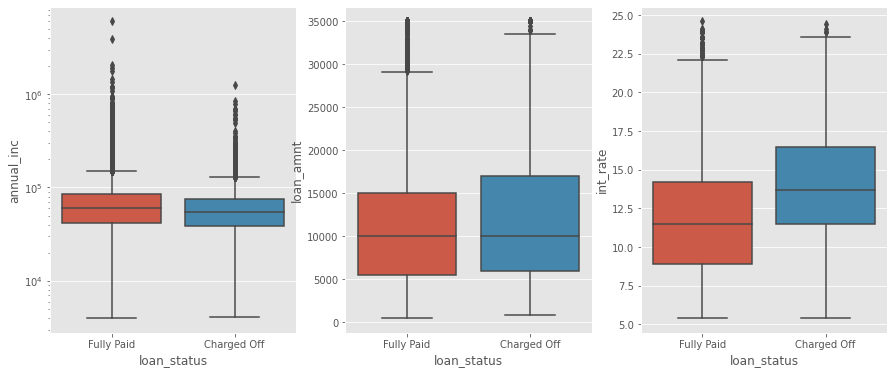

In [ ]:
fig, ax=plt.subplots(1,3)
sns.boxplot(y='annual_inc', x='loan_status', data=df, ax=ax[0]).set_yscale('log')
sns.boxplot(y='loan_amnt', x='loan_status', data=df, ax=ax[1])
sns.boxplot(y='int_rate', x='loan_status', data=df, ax=ax[2])
plt.show()

De los plots anteriores podemos ver que:

1. Un pequeño aumento en la mediana en `annual_inc` al comparar los usuarios que pagaron con los que no.

2. No vemos un cambio claro en la distribución de `loan_amnt`. Los usuarios que pagaron sus deudas en su totalidad parecen tener montos de préstamos ligeramente más bajos.

3. La diferencia entre usuarios que no pagaron y usuarios que pagador en la distribución de `int_rate` es más marcada. El box-plot para los usuarios que pagaron es más baja que la de los usuarios que no. Este resultado es el esperado, ya que las tasas de interés más altas aumentarían la cantidad real de dinero que un usuario tendría que pagar.




***¿Qué features ayudan o ayudarían a decidir si se otorga el préstamo o no?***

In [ ]:
## Vamos a hacer pruebas de t de medias.
df_numeric = df.select_dtypes(np.number)
## Prueba para cada feature numérica
for feature in df_numeric:
  a = df[df['loan_status']=='Charged Off'][feature]
  b = df[df['loan_status']=='Fully Paid'][feature]
  T,p=ttest_ind(a,b)
  print(f't-test para la feature: {feature} tiene un p-valor de: {p:.5f}')

t-test para la feature: annual_inc tiene un p-valor de: 0.00000
t-test para la feature: int_rate tiene un p-valor de: 0.00000
t-test para la feature: loan_amnt tiene un p-valor de: 0.00000


En todos los casos el $p$-valor es pequeño, hay suficiente evidencia estadística para decir que las dos distribuciones tienen medias diferentes. Con esta 'ayuda' podemos pensar en hacer uso de esta features como factor para decicir la probación de préstamos.

### ***Modelado de la situación.***

Vamos a considerar un modelo lineal de la siguiente forma:

$$p=\beta_0+\beta_1*\text{int_rate}$$

Donde $p=P(Y=1)$, es decir, la probabilidad de que la persona haga el pago. Recordemos que los modelos lineales buscan estimar el valor esperado de la variable Target, en este como consideramos a `loan_status` con distribución de Bernoulli.

In [ ]:
## Formamos el Dataset de trabajo.
## En este caso debemos definir valores númericos para las categorías de la variables Target.
## Consideraremos que Fully Paid = 1 y que Charge Off = 0.
df1 = df.copy()
df1 = df1[['loan_status','int_rate']]
df1['loan_status'] =  df1['loan_status'].apply(lambda x: 0 if x == 'Charged Off' else 1)
df1['loan_status'] = df1['loan_status'].astype('int')
df1.head()

,loan_status,int_rate
0,1,10.65
1,0,15.27
2,1,15.96
3,1,13.49
4,1,12.69


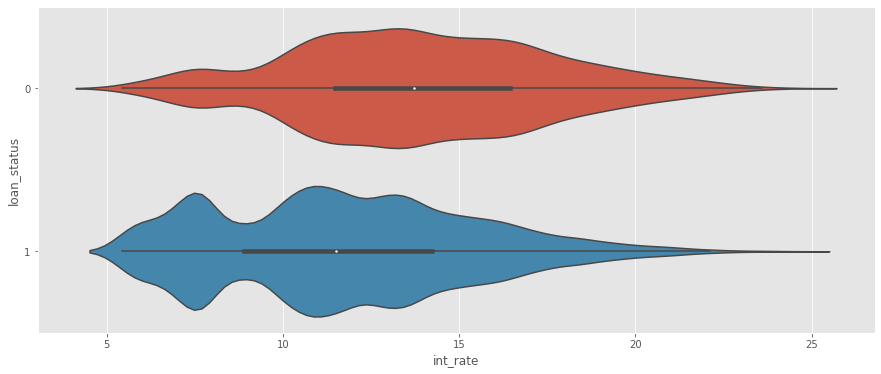

In [ ]:
##
temp = df1.copy()
temp['loan_status'] = temp['loan_status'].astype('category')
sns.violinplot(data = temp, x = 'int_rate', y = 'loan_status')
plt.show()

Recordemos que el box-plot para la feature `int_rate` muestra una diferencia entre los 2 niveles de la variable target. Más precisamente, el box-plot exhibe la diferencia entre usuarios con `Charged Off` (0) y `Fully Paid` (1), pues, para los usuarios con `Fully Paid` los valores de  la feature lucen más 'bajos' que para el caso de  `Charged Off`. Pensemos que si tenemos un sistema que solo usara esta característica para separar los grupos, tendríamos un solapamiento, algo que no es ideal.

In [ ]:
## Regresión lineal
model_lm = smf.ols(formula='loan_status~int_rate', data=df1).fit()
print(model_lm.summary())

                            OLS Regression Results                            
Dep. Variable:            loan_status   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     1614.
Date:                Sat, 26 Nov 2022   Prob (F-statistic):               0.00
Time:                        17:35:56   Log-Likelihood:                -13225.
No. Observations:               38705   AIC:                         2.645e+04
Df Residuals:                   38703   BIC:                         2.647e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0849      0.006    184.735      0.0

In [ ]:
## Regresión lineal OTRA OPCIÓN.
#df1['intercept'] = 1
#model_lm = sm.OLS(endog=df1['loan_status'], exog=df1.drop(columns = ['loan_status'])).fit()
#print(model_lm.summary())

El $p$-valor de la prueba global de significancia del modelo muestra que si es posible hacer uso de esta feature para explicar las diferencias entre las probabilidades de la variable Target. Veamos la recta de ajuste:

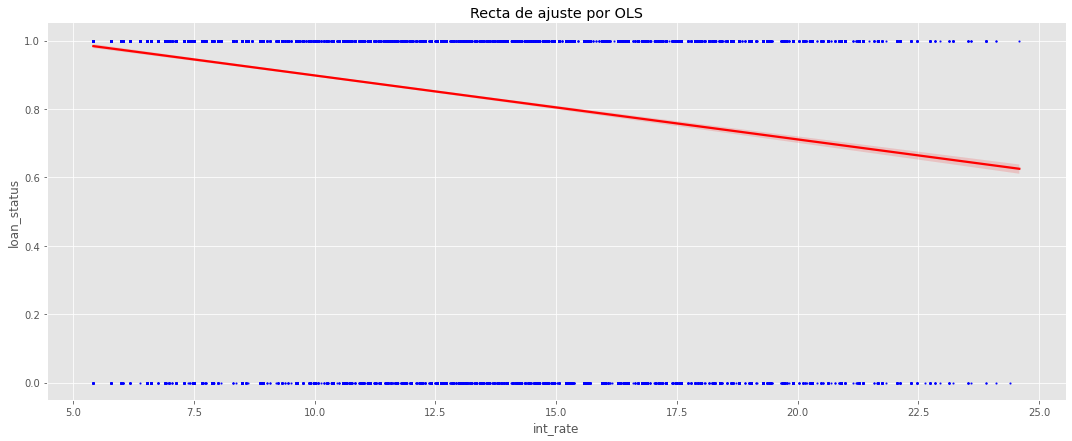

In [ ]:
sns.lmplot(data=df1,  x='int_rate', y='loan_status', line_kws={'color': 'red'}, height=6,
           aspect=2.5, scatter_kws={'color':'blue','s': 1.5})
plt.title('Recta de ajuste por OLS')
plt.show()

Notemos que la recta dificilmente se ajusta al conjunto de puntos de la variable Target, además:


In [ ]:
## Predicción del modelo con un valor de interés del 4%
model_lm.predict({'int_rate':4})

0    1.010154
dtype: float64

En el caso anterior vemos que para una tasa de interés del $4\%$ se obtiene una probabilidad mayor que 1 (imposible!).

### ***odds o razón de probabilidades***

Los odds de un evento es la relación entre su probabilidad de éxito y su probabilidad de fracaso. Tomenos $Y~\sim Bernoulli(p)$, donde $p$ es la probabilidad de éxito, así:

$$
\text{Odds}(Y=1) = \frac{p}{1-p}
$$

- ***Ejemplo 1:*** Supongase que en una distribución de Bernoulli la probabilidad de que se obtenga un éxito es $0.8$, luego la probabilidad de fracaso será $0.2$, así:

$$
\text{Odds} = \frac{0.8}{0.2}=4
$$

Esto equivale a decir que se esperan 4 éxitos por cada 1 fracaso.

- ***Ejemplo 2:*** De igua forma, suponga ahora que en una distribución de Bernoulli la probabilidad de que se obtenga un éxito es $0.3$, luego la probabilidad de fracaso será $0.7$, así:

$$
\text{Odds} = \frac{0.3}{0.7}=\frac{3}{7}
$$

Esto equivale a decir que se esperan 3 éxitos por cada 7 fracasos.


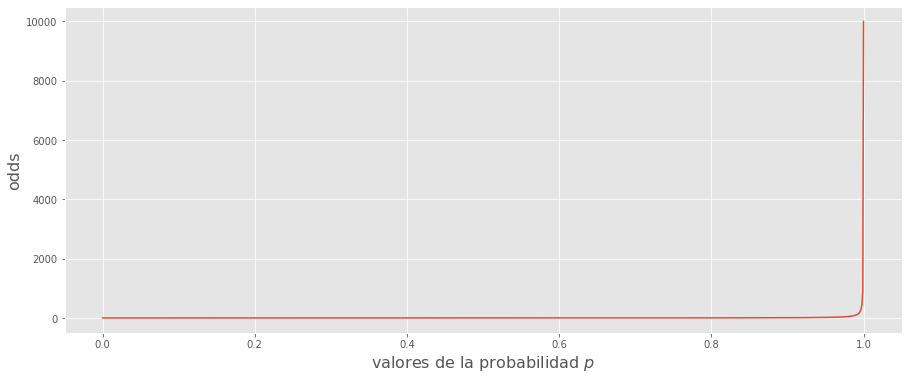

In [ ]:
## Gráfica de los odds.
values_p = np.linspace(0.0001,0.9999,1000)
odds = (values_p)/(1-values_p)
plt.plot(values_p,odds)
plt.xlabel('valores de la probabilidad $p$', size=16)
plt.ylabel('odds', size=16)
plt.show()

El plot anterior muestra como los odds toman valores de $(0,∞)$, deseamos que también se toman valores negativos, que es lo que secude en un modelo lineal.

### ***Función logit***


Aunque hemos logrado que se logren tomar cualquier valor real positivo, aún debemos lograr que se tomen valores negativos para ajustar un modelo lineal.

Vamos a considerar la función:

$$logit(p)=\ln\left(\frac{p}{1-p}\right)$$

Esta función tiene dominio en $(0,1)$ y rango en todos los reales.

### ***Odds ratio***

El concepto clave es entender los ***odds ratio***, esto no otra cosa que un cociente de ***odds***. Vamos a suponer que tenemos una feature categórica $X$ de dos niveles (0 y 1). Luego los ***odds ratio*** vienen dados por:

$$\text{odds ratio}=\frac{odds(p(Y=1|X=1))}{odds(p(Y=1|X=0))}$$

Lo anterior se interpreta como:

***los odds de que $Y=1$ cuando $X=1$ versus los odds de $Y=1$ cuando $X=0$.***

Por ejemplo, si ***odds ratio*** es igual a 2, entonces ***los odds para $Y=1$ son dos veces mayores cuando $X=1$ versus cuando $X=0$.***

***Nota:*** Se debe trabajar en términos de ***odds ratio*** por que los coeficientes $β_j$ en la regresión logística son el logaritmo natural de los ***odds ratio*** para $X_j$.

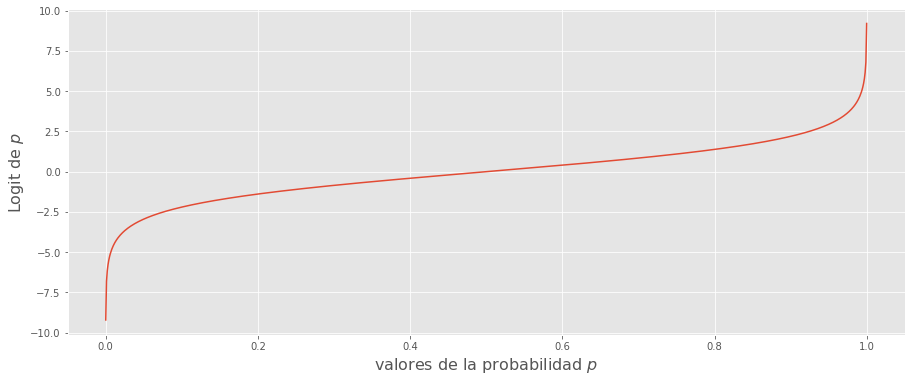

In [ ]:
## Gráfica de log_odds.
log_odds = np.log(odds)
plt.plot(values_p,log_odds)
plt.xlabel('valores de la probabilidad $p$', size=16)
plt.ylabel('Logit de $p$', size=16)
plt.show()

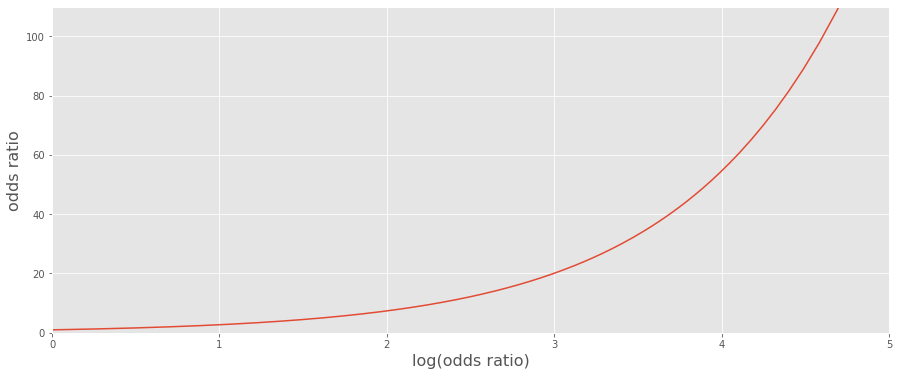

In [ ]:
## Plot log(odds ratio) vs. odds ratio
odds = odds[odds>1]
log_odds = np.log(odds)
plt.plot(log_odds,odds)
plt.xlabel('log(odds ratio)', size =16)
plt.ylabel('odds ratio', size =16)
plt.xlim((0,5))
plt.ylim((0,110))
plt.show()

El plot anterior muestra la relación entre los odds ratio y los logaritmos de los odds ratio  para
razones de probabilidad mayores que 1.

## ***Nuestro modelo de regresión logística simple.***

Con todo lo comentado anteriormente, para nuestro problema en particular, tomemos el modelo:

$$logit(p)=\ln\left(odds(Y=1)\right)=\beta_0+\beta_1*\text{int_rate}$$

Este modelo relaciona la probabilidad $p=P(Y=1)$ y el modelo lineal general.

In [ ]:
## Implementación Logistic Regression logit.
lr_logit1 = smf.logit(formula='loan_status~int_rate', data=df1).fit()
print(lr_logit1.summary())

Optimization terminated successfully.
         Current function value: 0.386210
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:                38705
Model:                          Logit   Df Residuals:                    38703
Method:                           MLE   Df Model:                            1
Date:                Sat, 26 Nov 2022   Pseudo R-squ.:                 0.04865
Time:                        18:23:46   Log-Likelihood:                -14948.
converged:                       True   LL-Null:                       -15713.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.7810      0.056     67.091      0.000       3.671       3.891
int_rate      -0.1538      0.

### ***Interpretación de los coeficientes en la salida de una regresión logística***

El signo del coeficiente de regresión aún representa la dirección de influencia de una variable específica: ***un coeficiente positivo significa que la probabilidad de pago aumentará si la variable asociada aumenta y viceversa.***

Por supuesto, otra parte importante de la información al interpretar un modelo de regresión logística es el $p$-valor para cada coeficiente de regresión.

En todos los casos se está contrastando las hipótesis:

$$H_0: \beta_i = 0$$
$$vs$$
$$H_1: \beta_i \neq 0$$

Es decir, ***rechazar la hipótesis nula, significa que la diferencia en la probabilidad de pago está asociada con cambios en la variable correspondiente.***

Nuestro modelo ajustado será:

$$\ln\left(odds\right)=3.7810-0.1538*\text{int_rate}$$

Supongamos además, que tenemos un incremento unitario en la feature `int_rate` pasando de una cantidad $x_{i}$ a $x_i+1$, por lo tanto:


$$\frac{odds_{x_i+1}}{odds_{x_i}}=exp(-0.1538)=0.8574≈\frac{85}{100}$$

Es decir, por cada 100 éxitos que se tenían cuando $\text{int_rate}=x_i$, se paso a tener 85 éxitos, es decir, ***los odds de pagar el préstamo decrecen aproximadamente en un $15\%$, por cada aumento de un punto en la tasa de interés.***


***El `Pseudo R-squ.`. es una métrica similar a R-cuadrado para modelos lineales. Si este número es grande, entonces las variables en el modelo explican una gran parte de los 'impulsores' de la tendencia de las personas a pagar su deuda. En este caso, la es de solo del $4.8\%$.***

In [ ]:
## Implementación segundo modelo LR con una variable categórica.
df2 = df.copy()
df2 = df2[['loan_status','home_ownership','int_rate']]
##
df2['loan_status'] = df2['loan_status'].astype(pd.api.types.CategoricalDtype(
    categories=['Charged Off','Fully Paid']))
df2['loan_status'] = df2.loan_status.cat.codes
##
df2['home_ownership'] = df2['home_ownership'].astype(pd.api.types.CategoricalDtype(
    categories=['RENT', 'OWN', 'MORTGAGE', 'OTHER']))
##
lr_logit2 = smf.logit(formula='loan_status~int_rate+home_ownership', data=df2).fit()
print(lr_logit2.summary())

Optimization terminated successfully.
         Current function value: 0.386064
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:                38705
Model:                          Logit   Df Residuals:                    38700
Method:                           MLE   Df Model:                            4
Date:                Sat, 26 Nov 2022   Pseudo R-squ.:                 0.04901
Time:                        17:36:11   Log-Likelihood:                -14943.
converged:                       True   LL-Null:                       -15713.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      3.7392      0.059     63.666      0.000      

***Interpretación:***

Como la feature `home_ownership` tiene los niveles: RENT, OWN, MORTGAGE y OTHER y el coeficiente de regresión para `home_ownership[T.MORTGAGE]` es $0.0931$, entonces:

$$\frac{odds(MORTGAGE)}{odds(RENT)}=exp(0.0931)=1.0975$$

***Luego, los odds para MORTGAGE (hipoteca) es 1.0975 veces más que los odds para RENT (arrendado). Es decir, la ventaja para finalmente pagar el crédito es $9\%$ más en MORTGAGE que en RENT***

Con las demás variables categóricas es muy similar el análisis.




### ***Predicciones***

Recordemos que estamos estimando la probabilidad de que la variable Target (`loan_status`), sea un éxito, dada la información en las features `int_rate` y `home_ownership`. Las predicciones de la probabilidad se encuentran con la expresión:

$$\hat{p}=\frac{1}{1+exp(-\hat{Y})}$$

Donde:

1. $\hat{Y}= 3.7391+0.005786*\text{home_ownership[T.OWN]}+ 0.093087*\text{home_ownership[T.MORTGAGE]}-0.346762*\text{home_ownership[T.OTHER]}-0.153589*\text{int_rate}$

2. $\hat{p}$ es la estimación de $P(Y=1|\text{regresores})$

In [ ]:
## Parámetros estimados.
lr_logit2.params

Intercept                     3.739158
home_ownership[T.OWN]         0.005786
home_ownership[T.MORTGAGE]    0.093087
home_ownership[T.OTHER]      -0.346762
int_rate                     -0.153589
dtype: float64

In [ ]:
## Predicciones vía el modelo de regresión logística.
predict_lr_logit2 = lr_logit2.predict(df2.drop(columns=['loan_status']))
predict_lr_logit2

0        0.891237
1        0.801207
2        0.783787
3        0.841208
4        0.856941
           ...   
38700    0.930396
38701    0.896624
38702    0.930396
38703    0.936498
38704    0.836593
Length: 38705, dtype: float64

Notemos que el modelo ***NO predice*** la categoría de la observación, solo muestra una probablidad de ser parte de la categoría objetivo de la variable Target.

### ***Evaluación de modelos de clasificación***

En el modelado predictivo se acostumbra a entrenar varios modelos diferentes, luego evaluar los diferentes modelos en el conjunto `test` y evaluar su desempeño. La idea de evaluación del modelo será saber qué modelo produce la información más precisa y útil en las predicciones.

In [ ]:
## log(odds) son los valores ajustados del modelo.
log_odds = lr_logit2.fittedvalues
log_odds.head()

0    2.103434
1    1.393853
2    1.287876
3    1.667241
4    1.790112
dtype: float64

In [ ]:
log_odds = lr_logit2.fittedvalues
p_hat = 1/(1+np.exp(-log_odds))
## True labels
true_label = df2['loan_status']
## Corte en 0.5: 1 si es mayor o igual 0.5 y 0 en otro caso.
prediction = round(p_hat).astype('int8')
##
temp = pd.DataFrame({'proba':p_hat, 'predict': prediction, 'true_label': true_label})
temp

,proba,predict,true_label
0,0.891237,1,1
1,0.801207,1,0
2,0.783787,1,1
3,0.841208,1,1
4,0.856941,1,1
...,...,...,...
38700,0.930396,1,1
38701,0.896624,1,1
38702,0.930396,1,1
38703,0.936498,1,1


### _**[Matriz de confusión](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)**_

Un resumen muy importante de la clasificación es la matriz de confusión. La matriz de confusión es una tabla que muestra el número de predicciones correctas e incorrectas etiquetadas en los siguientes cuatro términos:


- ***True positives (TP):*** Es el número de predicciones corretas del modelo en la categoría 1.
- ***False negative (FN):*** Es el número de predicciones que el modelo etiquetó con 0 cuando la categoría real era 1.

_Los dos anteriores corresponderán a la primera fila de nuestra construcción de la matriz de confusión._

- ***False positives (FP):*** Es el número de predicciones que el modelo etiquetó con 1 cuando la categoría real era 0.
- ***True negatives (TN):*** Es el número de predicciones correctas del modelo en la categoría 0.

_Los dos anteriores corresponderán a la segunda fila de nuestra construcción de la matriz de confusión._



<div align='center'><img src='https://raw.githubusercontent.com/lacamposm/Metodos_Estadisticos/main/data/images/confution_matrix.png' width=400>

_**Tomado de [acá](https://towardsdatascience.com/confusion-matrix-un-confused-1ba98dee0d7f)**_
</div>

In [ ]:
## Confusion matrix
cm = confusion_matrix(true_label,prediction, labels = [1,0])
cm

array([[33265,     0],
       [ 5439,     1]])

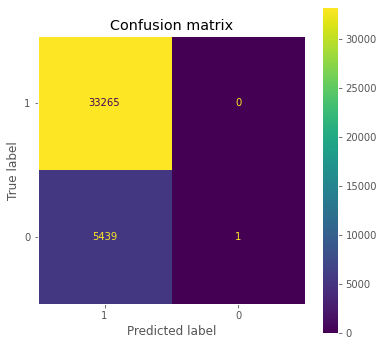

In [ ]:
## Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,0])
## Plot confusion matrix
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax)
plt.grid(False)
plt.title('Confusion matrix')
plt.show()

***Nota:***

1. La suma en la filas proporciona la realidad de la información, es decir, la suma de cada fila proporciona la cantidad de verdaderos miembros en las correspondientes etiquetas.

2. La suma en las columnas proporciona las predicciones del modelo, es decir, la suma de cada columna proporciona la cantidad de miembros predecidos en las correspondientes etiquetas.

### _**[Accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)**_

Una forma sencilla de medir el rendimiento de la clasificación es contar la proporción de predicciones que son correctas, es decir, medir la precisión. El `accuracy` es simplemente una medida de error total:


$$accuracy =\frac{TP+TN}{TP+FN+FP+TN}$$


En la mayoría de los algoritmos de clasificación, a cada registro se le asigna una _“probabilidad estimada de
ser de la categoría 1.”_  El punto de decisión predeterminado, o _cutoff_, suele ser 0,50 o 50 %. Si la probabilidad está por encima de 0,5, la clasificación es '1'; de lo contrario, es '0'.

In [ ]:
## accuracy de sklearn  ## Logra clasificar correctament cerca del 86% de los registros
## ¿Piensa usted que con este resultado es suficiente?
print('precision model lr_logit2:',round(accuracy_score(true_label, prediction),5))

precision model lr_logit2: 0.85948


### ***Precision, Recall y specificity.***


- _**[Precision:](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html)**_ Mide la exactitud de una predicción positiva (categoría 1).

$$precision = \frac{TP}{TP+FP}$$

Es decir, la proporción de acierto en las predicciones de la categoría 1 del modelo.

- _**[Recall (sensitivity):](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html)**_ Mide la fuerza del modelo para predecir un resultado positivo (1), es decir, la proporción de los verdaderos 1 que el modelo identifica correctamente.

$$recall = \frac{TP}{TP+FN}$$

El recall también es llamado ***True positive rate***.

- _**[specificity:](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html)**_ Mide la capacidad de un modelo para predecir un resultado negativo (0), es decir, la proporción de verdaderos 0 que el modelo identifica correctamente como 0.

$$specificity=\frac{TN}{TN+FP}$$

In [ ]:
# precision_recall_fscore_support(true_label,prediction)

In [ ]:
## precision_score
print('precision:', round(precision_score(true_label,prediction),6))
## recall_score
print('recall:', round(recall_score(true_label,prediction),6))
## specificity
specificity = precision_recall_fscore_support(true_label,prediction)[1][0]
print('specificity:', round(specificity,6))
print('1-specificity:', round(1-specificity,6))

precision: 0.859472
recall: 1.0
specificity: 0.000184
1-specificity: 0.999816


### _**[Curva ROC.](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)**_

Existe una compensación entre el ***recall*** y la ***specificity***. Capturando más 1s
generalmente significa clasificar erróneamente más 0 como 1. La métrica que captura esta compensación es la curva de  'Receiver Operating Characteristics” (Características operativas del receptor), conocida como la curva ROC. La curva ROC traza el ***recall*** en el eje $y$ contra ***false positive rate*** (***1-specificity***) en el eje $x$. La curva ROC muestra el equilibrio entre el ***recall*** y la ***specificity*** a medida que cambia el límite para determinar cómo clasificar un registro.

El proceso para calcular la ROC curva es:

1. Ordene los registros por la probabilidad predicha de ser un 1, comenzando con el más probable y terminando en el menos probable.

2. Calcule para cada corte ***1-specificity*** y el ***recall***, luego se gráfican estos puntos.

In [ ]:
## Situación ideal
cm = confusion_matrix(true_label,true_label, labels = [1,0])
cm

array([[33265,     0],
       [    0,  5440]])

In [ ]:
## Situación ideal
cm = confusion_matrix(true_label,true_label, labels = [1,0])
print('recall:',cm[0,0]/sum(cm[0]))
print('1- specificity:',cm[1,0]/sum(cm[1]))

recall: 1.0
1- specificity: 0.0


In [ ]:
## La peor situación.
bad_label = true_label.apply(lambda x: 0 if x==1 else 1)
##
cm = confusion_matrix(true_label,bad_label, labels = [1,0])
print('recall:',cm[0,0]/sum(cm[0]))
print('1- specificity:',cm[1,0]/sum(cm[1]))

recall: 0.0
1- specificity: 1.0


In [ ]:
## Situación de elección al azar (sin ningún criterio)
temp = np.random.binomial(1,0.5,size = len(true_label))
cm = confusion_matrix(true_label,temp, labels = [1,0])
print('recall:',cm[0,0]/sum(cm[0]))
print('specificity:',cm[1,1]/sum(cm[1]))
print('1- specificity:',cm[1,0]/sum(cm[1]))

recall: 0.4968886216744326
specificity: 0.5049632352941177
1- specificity: 0.49503676470588237


#### ***Ejercicio 1:***

Calcule el _recall (TPR)_ y la _specificity (TNR)_ para el modelo `lr_logit2` con cut-off de $p = 0.8, 0.85, 0.9$. Comente en todos los casos. ¿Cuál de estos valores de corte crees que es mejor? Justifique.

In [ ]:
## Función para diferentes cut-off.
def cm_cut_off(true_label, p_hat, cut_value):
  cut = p_hat.apply(lambda x: 1 if x>cut_value else 0)
  cm = confusion_matrix(true_label,cut, labels = [1,0])
  TPR, TNR = cm[0,0]/(sum(cm[0])), cm[1,1]/sum(cm[1])
  print(f'Para el corte: {cut_value}')
  print(f'TPR={TPR:.4f} y TNR={TNR:.4f}')
  return None

In [ ]:
## cut-off de 0.8
cm_cut_off(true_label, p_hat, cut_value = 0.8)

Para el corte: 0.8
TPR=0.8403 y TNR=0.3290


Con un cut-off de $0.8$, tenemos un TPR alto y un TNR bajo, luego, este límite clasificaría correctamente a la mayoría de los 'buenos' prestarios, pero también dejaría mal clasificados a gran parte de los morosos, esto podría tener problemas pues se podría perder bastante dinero.

<div align='center'><img src='https://raw.githubusercontent.com/lacamposm/Metodos_Estadisticos/main/data/images/confution_matrix.png' width=400>

In [ ]:
## cut-off de 0.9
cm_cut_off(true_label, p_hat, cut_value = 0.9)

Para el corte: 0.9
TPR=0.3564 y TNR=0.8443


Con $p=0.9$ se detectaría correctamente gran parte de los morosos, pero se negarían muchos prestamos a usuarios que probablemente pagarán. Así, se podría perder clientes frente a posibles competidores pues descartamos 'buenos' clientes (que terminan pagando).

In [ ]:
## cut-off de 0.85
cm_cut_off(true_label, p_hat, cut_value = 0.85)

Para el corte: 0.85
TPR=0.6710 y TNR=0.5478


Siendo más conservadores, con $p=0.85$ se detectará un $67\%$ de los 'buenos' prestamistas y cerca del $54\%$ de los morosos. Esta podría ser una alternativa pues no perderíamos gran parte de clientes y el riesgo estaría maso menos contralado.


***Hay una compensación constante entre TPR y TNR. Por lo general, es difícil encontrar una regla con TPR y TNR altos al mismo tiempo. Las personas elegirán priorizar uno de ellos según el escenario particular. Por ejemplo, en nuestro caso, TNR suele ser más importante que TPR, ya que preferimos evitar prestar a los morosos que dejar de prestar a un buen candidato. En cualquier caso debe ser el cliente (entidad que contrata el servicio de analítica) que enfoque tomar, uno más seguro u otro más arriesgado.***

### ***Construcción del sistema perfecto de clasificación.***

El clasificador ideal haría un excelente trabajo al clasificar los 1, sin clasificar erróneamente 0 como 1. La curva ROC de la situación ideal es la siguiente:

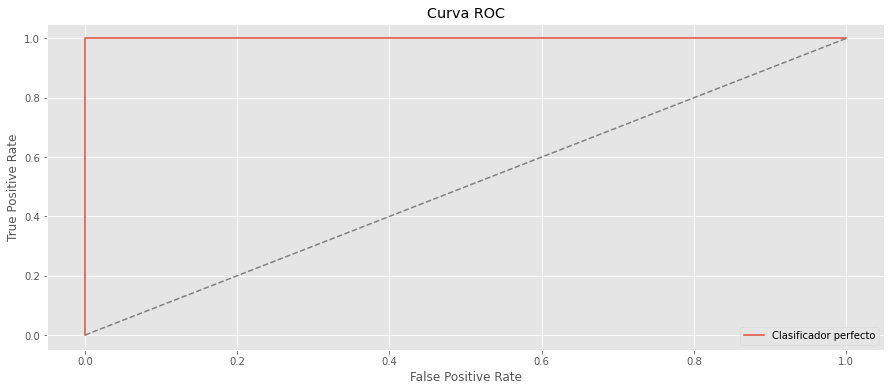

In [ ]:
plt.plot((0,0,1),(0,1,1), label = 'Clasificador perfecto')
plt.title('Curva ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot((0,1), (0,1), ls = '--', color = 'grey')
plt.legend()
plt.show()

***Vamos o buscar recrear la situación ideal con un sistema inteligente.***

***Paso 1:***  Al tener unas probabilidades estimadas, debemos seleccionar un ***cut-off*** para que nuestro sistema prediga 1s y 0s. Vamos a iniciar con probabilidad de 1, es decir todos los registros el sistema los clasifica como 0.



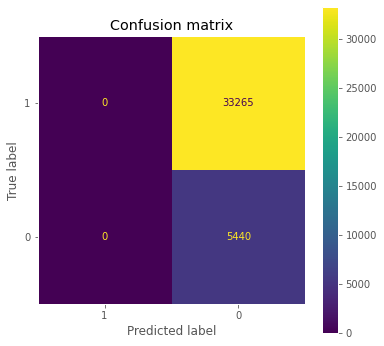

In [ ]:
## Lo que sucede en nuestro sistema actual.
all_zeros = pd.Series([1 if p_hat ==1 else 0  for p_hat in p_hat])
cm = confusion_matrix(true_label,all_zeros, labels = [1,0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,0])
## Plot confusion matrix
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax)
plt.grid(False)
plt.title('Confusion matrix')
plt.show()

Con la matriz de confusión anterior tenemos que:

$$TPR = 0 \text{ y } FPR=0$$

- ***Paso 2:***  Vamos a cambiar el ***cut-off***, si el sistema es el ideal debe existir un valor $p_0\in(0,1)$, tal que se obtenga que $FP=FN=0$. Pensando en el sistema ideal, si $p_1$ es cualquier valor en $[p_0,1)$ entonces $TP$ debe ser diferente de 0 (y creciendo) y $FP$ debe permanecer en 0. Así $TPR$ debe aumentar hasta llegar a 1 (esto ocurre cuando el corte es $p_0$) y $FPR=0$, formando la recta vertical de la curva ROC.  

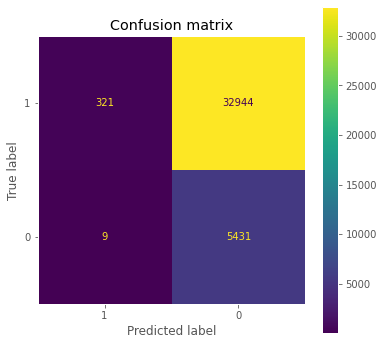

In [ ]:
## Para nuestro nuestro caso tenemos.
cut_off_09  = pd.Series([1 if p_hat > 0.952 else 0  for p_hat in p_hat])
cm = confusion_matrix(true_label,cut_off_09, labels = [1,0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,0])
## Plot confusion matrix
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax)
plt.grid(False)
plt.title('Confusion matrix')
plt.show()

***Nuestro sistema no puede ser el perfecto :(***

- ***Paso 3.*** Siguiendo con nuestro sistema perfecto, cuando tomamos un ***cut-off menor que $p_0$***, debe suceder que $TPR$ no aumente ni disminuya ($TPR=1$), pero quien empezará a aumentar será $FPR$, hasta llegar al valor de 1. Este valor de $FPR=1$ se obtiene cuando el modelo precide todo 1, formando la recta horizontal de la curva ROC.

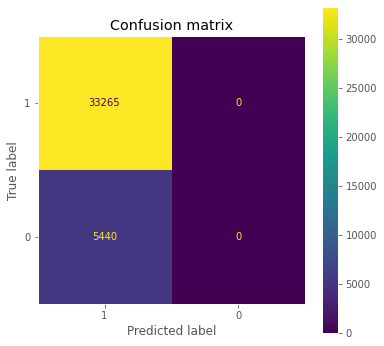

In [ ]:
## Para nuestro nuestro caso tenemos.
all_ones  = pd.Series([1 for p_hat in p_hat if p_hat >0])
cm = confusion_matrix(true_label,all_ones, labels = [1,0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,0])
## Plot confusion matrix
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax)
plt.grid(False)
plt.title('Confusion matrix')
plt.show()

Note que si el sistema es el ideal, el área bajo la curva ROC, llamada ***AUC*** es igual 1. Por lo tanto, ¿qué deseamos que suceda con nuestro sistema al realizar la curva ROC y encontrar su correspondiente ***AUC***?

### _**[AUC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)**_

Una forma de resumir toda la curva ROC es calculando el **área bajo la curva (AUC)**. En términos generales, AUC indica la ***probabilidad de que un moroso seleccionado al azar tenga una probabilidad $p$ más pequeña que un no moroso seleccionado al azar.***



In [ ]:
fpr, tpr, thresholds = roc_curve(true_label,p_hat)

In [ ]:
## fpr: False-Positive-Rate se define como: 1-specificity. Es la proporción de los verdaderos 0's que
## el modelo clasifica mal.
##
## tpr: True-positive-Rate: Es la proporción de los verdaderos 1's que el modelo clasifica bien.

In [ ]:
## auc
print('AUC para el modelo lr_logit2: {:.4f}'.format(auc(fpr,tpr)))

AUC para el modelo lr_logit2: 0.6615


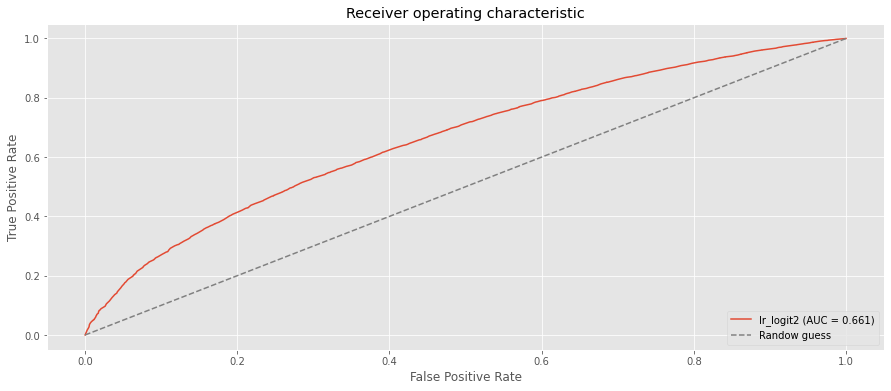

In [ ]:
## Plot curva ROC.
fpr, tpr, thresholds = roc_curve(true_label,p_hat) ## Esta en una celda anterior pero recuerde
roc_auc = auc(fpr, tpr)                            ## que siempre lo debe usar para la construcción de
plt.plot(fpr,tpr,label = 'lr_logit2 (AUC = {:.3f})'.format(roc_auc),)   ## la curva ROC.
plt.plot((0,1), (0,1), ls = '--', color = 'grey', label = 'Randow guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc='lower right')
plt.show()

En el plot anterior, la línea diagonal punteada corresponde a un clasificador que no mejora el azar. Un clasificador extremadamente eficaz ***tendrá un ROC que abraza la esquina superior izquierda; identificará correctamente muchos 1 sin clasificar erróneamente muchos 0 como 1.***

Para este modelo, si queremos un clasificador con una specificity de al menos el 50%, entonces el recall
es alrededor del 70%.

In [ ]:
## DataFrame con las tasas y el threshold
#pd.DataFrame({'FPR':fpr, 'TPR':tpr ,'hf':thresholds})

## ***¿Qué importancia tiene la fuente de ingresos de un solicitante de préstamo en línea?***

## ***Buscando solucionar el problema comercial.***

Una metodología para construir nuestro modelo final de clasificación binaria, es determinar cuales features son más viables para lograr el objetivo, es decir, un sistema que logre separar las clases, con la menor cantidad de errores.

Vamos a usar tablas de contingencias para buscar determinar la relación entre la variable Target con las demás categóricas.

In [ ]:
crosstab = pd.crosstab(df['verification_status'], df['loan_status'], margins = True)
crosstab['Fully Paid(%)'] = round(crosstab['Fully Paid']/crosstab['All']*100, 2)
crosstab

loan_status,Charged Off,Fully Paid,All,Fully Paid(%)
verification_status,,,,
Not Verified,2050,14449,16499,87.58
Source Verified,1413,8406,9819,85.61
Verified,1977,10410,12387,84.04
All,5440,33265,38705,85.94


La tabla anterior muestra algo que parece NO tener una situación natural, es decir, las solicitudes con `Not Verified` tienen un porcentaje mayor (aunque muy cercano) de cumplimiento de pago comparado con las demás categorías, esto lleva a pensar que es más probable que estos finalmente realicen el pago. Quizá esta verificación sea una perdida de tiempo, aunque debemos tener en mente que se podría darse el caso de que gran parte de los préstamos con tasas de interés menor se otorgaron a usuarios que no fueron verificados.

Por supuesto la herramienta que nos ayudará a verificar si estadísticamente hay relación o no entre la variable Target y esta variable será una prueba $\chi^{2}$ de independencia.

In [ ]:
cross = pd.crosstab(df['verification_status'],df['loan_status'])
chi2, p, dof, ex = chi2_contingency(cross)
print('verification_status: p-value of chisquare test =', p)

verification_status: p-value of chisquare test = 6.884998281535999e-17


***Luego, las asociaciones entre `loan_status` y `verification_status` son estadísticamente significativas.***

Tenga en cuenta que esta prueba sugiere que existe una diferencia significativa en la probabilidad de pago en los tres niveles, más no una tendencía.

### ***Tablas de contigencia estratificadas de `verification_status` vs. `loan_status`***

Se hace necesario ajustar otras variables para eliminar posibles impactos de confusión. Si queremos saber si `verification_status` realmente está asociado con `loan_status` como lo indica la tabla de contingencia anterior, deberíamos considerar estratificar la tabla de contingencia entre `loan_status` y `verification_status` por otras variables que también están asociadas con `loan_status` .

In [ ]:
ct_stra = pd.crosstab(index=[df['home_ownership'],df['verification_status']],
                      columns = df['loan_status'], margins = True)
ct_stra['Fully Paid (%)'] = round(ct_stra['Fully Paid']/ct_stra['All']*100,2)
ct_stra.drop(columns='All').drop('All', level=0)

loan_status                         Charged Off  Fully Paid  Fully Paid (%)
home_ownership verification_status                                         
MORTGAGE       Not Verified                 798        6064           88.37
               Source Verified              487        3443           87.61
               Verified                     983        5480           84.79
OTHER          Not Verified                  10          42           80.77
               Source Verified                1           9           90.00
               Verified                       7          29           80.56
OWN            Not Verified                 170        1210           87.68
               Source Verified              110         622           84.97
               Verified                     122         611           83.36
RENT           Not Verified                1072        7133           86.93
               Source Verified              815        4332           84.17
               Verified                     865        4290           83.22

La tabla anterior muestra que la tendencia se mantiene cuando se estratifica por la feature `home_ownership`, es decir, la proporción de usuarios con pago disminuye a medida que el estado de verificación es más confiable, sin importar el nivel. Note que tenemos una excepción en el nivel `OTHER`, pero al tener tan pocos usuarios en este segmento, la información no es muy confiable.

In [ ]:
ct_stra = pd.crosstab(index=[df['term'],df['verification_status']],
                      columns = df['loan_status'], margins = True)
ct_stra['Fully Paid (%)'] = round(ct_stra['Fully Paid']/ct_stra['All']*100,2)
ct_stra.drop(columns='All').drop('All', level=0)

loan_status                     Charged Off  Fully Paid  Fully Paid (%)
term       verification_status                                         
 36 months Not Verified                1580       12574           88.84
           Source Verified              688        6132           89.91
           Verified                     805        6505           88.99
 60 months Not Verified                 470        1875           79.96
           Source Verified              725        2274           75.83
           Verified                    1172        3905           76.92

En este caso la tendencia no se mantiene pues la proporción de usuarios con `Fully Paid`  en un plazo más corto permanece igual en los distintos niveles de `verification_status` cerca del $89\%$.

***Comentarios:***

Al comparar las tablas estratificadas con las no-estratificadas deberiamos observar lo siguiente:

1. Si nos basamos en la tabla de contingencias estratificadas, la diferencia en la probabilidad de PAGAR entre los verificados y no-verificados podría ser atribuible al efecto del plazo del préstamo. En la tabla estratificada por `term` la proporción de préstamos totalmente pagados sigue siendo muy similar en los diferentes niveles de `verication_status` cuando fijamos el `term`. Por otro lado, la probabilidad de `Fully Paid` en cada estrato específico es bastante diferente, cerca del $89\%$ para 36 meses y cerca del $78\%$ para 60 meses.

2. Si nos basamos en la tabla de contingencias estratificadas, la diferencia en la probabilidad de PAGAR entre los verificados y no-verificados NO ES atribuible (al parecer) al efecto de `home_ownership`. Esto tiene todo el sentido pues no hay cambios significativos en la proporciones de préstamos pagados.

***Pregunta.***

Vamos a suponer que los usuarios que NO tienen los ingresos verificados, tiene más probabilidad de pedir préstamos a CORTO PLAZO en comparación con los usuarios con ingresos verificados. Adicionalmente, que los usuarios con préstamos a corto plazo tiene más probabilidades de pagar sus deudas.

***Si fuera el caso que `verification_status` no tiene efecto en la probabilidad de PAGAR la deuda. ¿Los usuarios sin ingresos verificados están en el margen más probable a pagar su deuda?***


***Respuesta:***

***SI!!!!****



In [ ]:
## Modelo con variables numéricas + verification_status
df3 = df.copy()
df3 = df3[['int_rate', 'annual_inc','loan_status','loan_amnt', 'verification_status']]
df3['loan_status'] =  df3['loan_status'].apply(lambda x: 0 if x == 'Charged Off' else 1)
df3['verification_status'] = df3['verification_status'].astype('category')
##
lr_logit3 = smf.logit(formula = 'loan_status ~ int_rate + annual_inc + loan_amnt+verification_status',
                      data = df3).fit()
print(lr_logit3.summary())

Optimization terminated successfully.
         Current function value: 0.383396
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:                38705
Model:                          Logit   Df Residuals:                    38699
Method:                           MLE   Df Model:                            5
Date:                Sat, 26 Nov 2022   Pseudo R-squ.:                 0.05558
Time:                        17:36:18   Log-Likelihood:                -14839.
converged:                       True   LL-Null:                       -15713.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                  3.5081   

In [ ]:
## Calculamos el valor del AUC
p_hat3 = lr_logit3.predict(df3.drop(columns=['loan_status']))
fpr3, tpr3, thresholds3 = roc_curve(df3['loan_status'],p_hat3)
print('AUC:',auc(fpr3, tpr3))

AUC: 0.673453821142165


### ***Modelo completo.***

Vamos a incorporar todas estas variables en el modelo logístico junto con `verification_status` y veamos si la tendencia decreciente asociada con `verification_status` todavía se mantiene.

In [ ]:
df_full = df.copy()
##
y = df_full['loan_status']
##
df_cate = df_full.select_dtypes('object').drop(columns=['loan_status'])
for column in df_cate.columns:
  df_cate[column] = df_cate[column].astype('category')
df_number = df_full.select_dtypes('number')
##
X = pd.concat([y,df_cate,df_number],axis = 1)
X['loan_status'] =  X['loan_status'].apply(lambda x: 0 if x == 'Charged Off' else 1)
## MODELO
formula1 = 'loan_status ~ int_rate + annual_inc + loan_amnt+'
formula2 = 'verification_status + emp_length + home_ownership + purpose + term+ grade'
lr_full = smf.logit(formula = formula1+formula2, data = X).fit()
print(lr_full.summary())
print()
##
p_hatF = lr_full.predict(X.drop(columns = ['loan_status']))
fpr, tpr, thresholds4 = roc_curve(X['loan_status'],p_hatF)
print('AUC:',auc(fpr, tpr))

Optimization terminated successfully.
         Current function value: 0.377925
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:                38705
Model:                          Logit   Df Residuals:                    38666
Method:                           MLE   Df Model:                           38
Date:                Sat, 26 Nov 2022   Pseudo R-squ.:                 0.06906
Time:                        17:36:19   Log-Likelihood:                -14628.
converged:                       True   LL-Null:                       -15713.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                  3.5159   

Con los resultados anteriores podemos comentar lo siguiente:

1. No hay evidencia que sustente la asociación entre la probabilidad de pago y el estado de verificación después de considerar otras variables.

2. Los ***odds de pago*** en los usuarios con grado B (`grade B`) disminuyen un $24\%$ sus chances aproximadamente en comparación con los usarios de grado A (`grade A`) teniendo en cuenta todas las varibles, esto pues

$$exp(-0.2728)=0.761$$



Note que ahora los coeficientes de regresión para `verification_status` son positvos comparados con el modelo `lr_logit3` aunque los $p$ siguen siendo grandes. Esto indica que después de ajustar todas las demás variables en el modelo, `verification_status` sigue sin mostrar diferencias asociadas con la chance de pago. ***¿Qué variables de confusión fueron las responsables de introducir la tendencia decreciente inicial?***

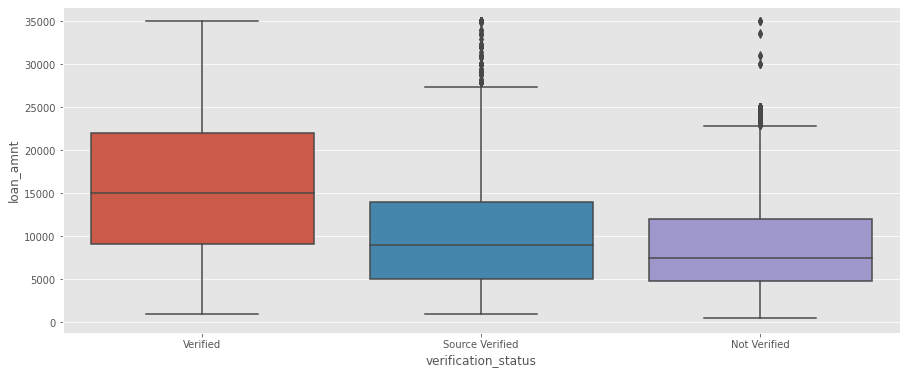

In [ ]:
sns.boxplot(y='loan_amnt', x='verification_status', data=df)
plt.show()

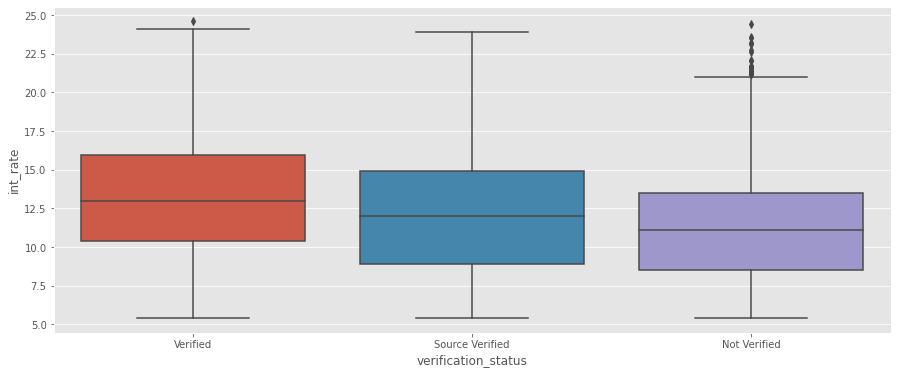

In [ ]:
sns.boxplot(y='int_rate', x='verification_status', data=df)
plt.show()

In [ ]:
res = pd.crosstab(df['verification_status'],df['emp_length'])
round(res.div(res.sum(axis = 1),axis = 0)*100, 4)

emp_length,1 year,10+ years,2 years,3 years,4 years,5 years,6 years,7 years,8 years,9 years,< 1 year
verification_status,,,,,,,,,,,
Not Verified,9.4127,20.1285,12.4311,11.0976,8.9763,8.5945,5.6731,4.4427,3.8245,3.3335,12.0856
Source Verified,8.5243,20.2465,11.2231,10.7139,8.7178,8.4836,5.7745,4.6542,3.5441,3.0349,15.0830
Verified,6.9185,28.9820,10.0186,9.8087,8.9368,8.3475,5.8771,4.7227,4.0849,3.3180,8.9852


***Comentarios:***

1. La tendencia marginal es que las personas con ingresos verificados tienden a pedir préstamos con tasas de interés más altas.

2. La tendencia marginal es que las personas con ingresos verificados tienden a pedir préstamos con mayores cuantias.

3. La tendencia marginal es que las personas con ingresos verificados tienden a tener un empleo más prolongado.

## ***¿Incluir  la feature `verification_status` en el modelo?***


Todo parece indicar que la inclusión de `verification_status` es no necesaria. Aunque el $p$-valor es una medida de la importancia o no de la inclusión de una feature al modelo, no siempre es la única manera de decidir que feature o no incluir, el mismo coeficiente puede ser un factor de no inclusión (piense en ***odds*** cercanos a 1). Tenga un cuenta que la tarea principal finalmente es la clasificación de la manera más 'correcta' posible, luego basaremos nuestra decisión final en la curva ROC y su área bajo la curva.

In [ ]:
## MODELO SIN 'verification_status'
formula_sin_vs1 = 'loan_status ~ int_rate + annual_inc + loan_amnt+emp_length +'
formula_sin_vs2 = 'home_ownership + purpose + term+ grade'
lr_full1 = smf.logit(formula=formula_sin_vs1+formula_sin_vs2, data=X).fit()
print(lr_full1.summary())

Optimization terminated successfully.
         Current function value: 0.377930
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:                38705
Model:                          Logit   Df Residuals:                    38668
Method:                           MLE   Df Model:                           36
Date:                Sat, 26 Nov 2022   Pseudo R-squ.:                 0.06905
Time:                        17:36:22   Log-Likelihood:                -14628.
converged:                       True   LL-Null:                       -15713.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         3.5168      0.152     23.088      0.

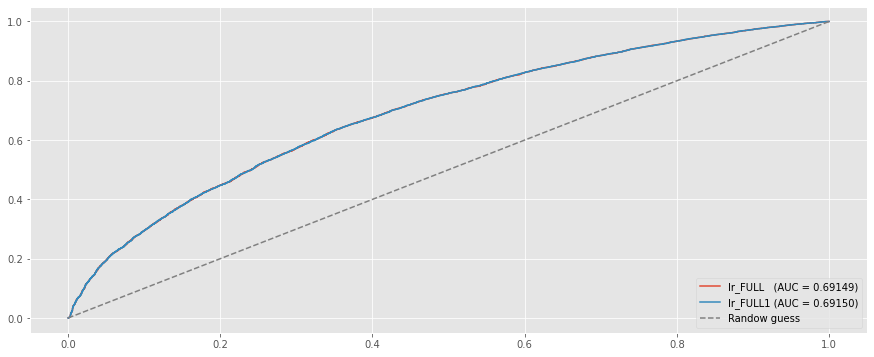

In [ ]:
## Curva ROC modelo FULL
predict = lr_full.predict(X.drop(columns = ['loan_status']))
fpr, tpr, thresholds = roc_curve(X['loan_status'],predict)
roc_auc = auc(fpr, tpr)
plt.plot(fpr,tpr,label = 'lr_FULL   (AUC = {:.5f})'.format(roc_auc),)
## Curva ROC modelo FULL SIN 'verification_status'
predict = lr_full1.predict(X.drop(columns = ['loan_status']))
fpr1, tpr1, thresholds1 = roc_curve(X['loan_status'],predict)
roc_auc1 = auc(fpr1, tpr1)
plt.plot(fpr1,tpr1,label = 'lr_FULL1 (AUC = {:.5f})'.format(roc_auc1),)
##
plt.plot((0,1), (0,1), ls = '--', color = 'grey', label = 'Randow guess')
plt.legend(loc='lower right')
plt.show()

***Encontramos que el AUC para el modelo con `verification_status` incluido es el mismo que el modelo sin `verification_status` incluido (0.69). Dado que siempre queremos que nuestro modelo sea lo más simple posible, esto significa que no debemos incluir `verification_status` como una variable al predecir si es probable que un usuario pague su deuda.***

## ***Conclusiones.***

En esta lectura, investigamos si el estado de verificación de la fuente de ingresos de los solicitantes es importante al predecir si un solicitante pagará su deuda. Construimos un modelo logístico para examinar primero la relación marginal entre el estado de verificación y la probabilidad de pago. Descubrimos una tendencia contraria a la intuición: la información de fuente de ingresos menos confiable se correlacionó con una mayor probabilidad de pago. Sin embargo, después de ajustar un modelo logístico más grande con todas las variables independientes disponibles, encontramos que esta tendencia se introdujo a través de los efectos de confusión de la tasa de interés, el ingreso anual y el plazo del préstamo.

Después de tener en cuenta estas variables, el estado de verificación ya no se asoció significativamente con la probabilidad de pago. Con base en los valores de $p$ y el modelo ROC, llegamos a la conclusión de que el proceso de verificación es irrelevante y que potencialmente podríamos eliminarlo de los elementos requeridos y simplificar el proceso de préstamo.

# _**Anexo: [Logistic Regression sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)**_

In [ ]:
### Vamos a probar la regresión logística de sklearn
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
##
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

In [ ]:
## Preparamos la Data
X,y = df.drop(columns = ['loan_status']), df['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123,
                                                    test_size=0.2, stratify=y)
##
feature_cat = [column for column in X_train.select_dtypes('object').columns]
X_train = pd.get_dummies(X_train, columns = feature_cat, drop_first=True)
X_test  = pd.get_dummies(X_test,  columns = feature_cat, drop_first=True)

In [ ]:
## Instanciamos la clase y entrenamos el modelo.
clf = LogisticRegression(penalty='none', solver='newton-cg')
clf.fit(X_train,y_train)

LogisticRegression(penalty='none', solver='newton-cg')

In [ ]:
## Coeficientes
coefs = np.concatenate((clf.intercept_.reshape(1,1), clf.coef_),axis=1)
list_betas = ['intercept']
list_betas.extend(X_train.columns)
##
#pd.DataFrame(np.transpose(coefs), index = list_betas, columns = ['betas'])

In [ ]:
## Probas estimadas
#clf.predict_proba(X_test)

In [ ]:
## Predicciones
y_pred = clf.predict(X_test); y_pred

array(['Fully Paid', 'Fully Paid', 'Fully Paid', ..., 'Fully Paid',
       'Fully Paid', 'Fully Paid'], dtype=object)

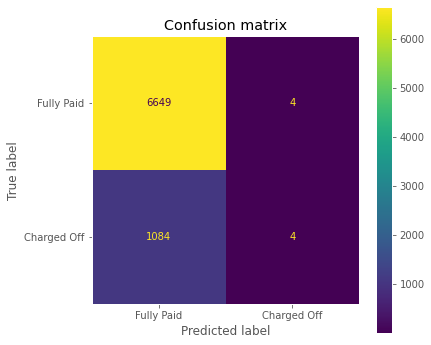

In [ ]:
## Matriz de confusión.
cm=confusion_matrix(y_test,y_pred, labels = ['Fully Paid','Charged Off'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fully Paid','Charged Off'])
## Plot confusion matrix
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax)
plt.grid(False)
plt.title('Confusion matrix')
plt.show()

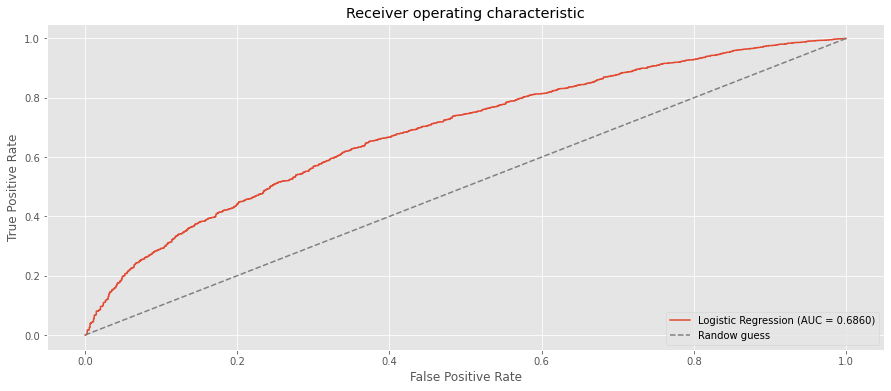

In [ ]:
## 0-->'Charged Off'; 1-->'Fully Paid'
y_tem = label_binarize(y_test, classes=['Charged Off','Fully Paid'])
## AUC en test.
fpr, tpr, thresholds = roc_curve(y_tem, clf.predict_proba(X_test)[:,1])
roc_auc = auc(fpr,tpr)
plt.plot(fpr, tpr, label='Logistic Regression (AUC = %0.4f)' % roc_auc)
plt.plot((0,1), (0,1), ls = '--', color = 'grey', label = 'Randow guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc='lower right')
plt.show()

In [ ]:
## Comparamos AUC's
print('AUC en Train:', roc_auc_score(y_train,clf.predict_proba(X_train)[:,1]))
print('AUC en Test:',  roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))

AUC en Train: 0.6920696115570928
AUC en Test: 0.6860121152774953


## ***Para selección automática de caracteristicas.***

El algoritmo [RFE](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html) (recursive feature elimination) usa la deviance del modelo


$$\left(-2\sum_{i=1}^n \left\{Y_i \ln(p_i)+(1-Y_i)\ln(1-p_i)\right\}\right)+K$$



In [ ]:
n = 25                                                           ## Número de variables a selecionar.
clf = LogisticRegression(penalty = 'none', solver = 'newton-cg')
clf.fit(X_test,y_test)
rfe = RFE(clf, n_features_to_select = n)                         ## 25 variables más importantes.
rfe.fit(X_train, y_train)
##
X_new_train = X_train[X_train.columns[rfe.ranking_==1]]
X_new_test  = X_test[X_test.columns[rfe.ranking_==1]]
## Ajustamos el modelo nuevamente
clf1 = LogisticRegression(penalty = 'none', solver = 'newton-cg')
clf1.fit(X_new_train, y_train)

LogisticRegression(penalty='none', solver='newton-cg')

In [ ]:
## rfe.feature_names_in_
## rfe.ranking_

In [ ]:
pd.DataFrame({'feature': rfe.feature_names_in_,'importancia':rfe.ranking_}, index = None)

,feature,importancia
0,annual_inc,13
1,int_rate,1
2,loan_amnt,14
3,verification_status_Source Verified,2
4,verification_status_Verified,3
5,emp_length_10+ years,10
6,emp_length_2 years,1
7,emp_length_3 years,1
8,emp_length_4 years,1
9,emp_length_5 years,6


In [ ]:
## Comparamos AUC's
print('AUC en Train:', roc_auc_score(y_train,clf1.predict_proba(X_new_train)[:,1]))
print('AUC en Test:',  roc_auc_score(y_test, clf1.predict_proba(X_new_test)[:,1]))

AUC en Train: 0.6821881470640732
AUC en Test: 0.6776540575459103
